**Notices**

Copyright (c) 2019 Intel Corporation.

Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files (the
"Software"), to deal in the Software without restriction, including
without limitation the rights to use, copy, modify, merge, publish,
distribute, sublicense, and/or sell copies of the Software, and to
permit persons to whom the Software is furnished to do so, subject to
the following conditions:

The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE
LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION
WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


# Data Wrangling with VMMRdb on CPU

## Objective

Understand ways to find a data set and to prepare a data set for machine learning and training.

## Activities 
**In this section of the training you will**
- Fetch and visually inspect a dataset 
- Create a dataset to address a real life problem
- Image Preprocessing
- Data Augmentation Techniques
- Address Imbalanced Dataset Problem
- Organize a dataset into training, validation and testing groups
- Finalize an augmented dataset for training, and testing

As you follow this notebook, complete **Activity** sections to finish this workload. 


### 1.1 Find a Data set

Artificial intelligence projects depend upon data. When beginning a project, data scientists look for existing data sets that are similar to or match the given problem. This saves time and money, and leverages the work of others, building upon the body of knowledge for all future projects. 

Typically you begin with a search engine query. For this project, we were looking for a data set with an unencumbered license.

This project starts with [Vehicle Make and Model Recognition Dataset (VMMRdb)](http://vmmrdb.cecsresearch.org/)   which is large in scale and diversity, containing 9,170 classes consisting of 291,752 images, covering models manufactured between 1950 to 2016. VMMRdb dataset contains images that were taken by different users, different imaging devices, and multiple view angles, ensuring a wide range of variations to account for various scenarios that could be encountered in a real-life scenario. The cars are not well aligned, and some images contain irrelevant background. The data covers vehicles from 712 areas covering all 412 sub-domains corresponding to US metro areas. VMMRdb dataset can be used as a baseline for training a robust model in several real-life scenarios for traffic surveillance. 

### 1.2 Subset of the Data

Although we used the initial data set during our initial exploration, we are only providing a subset of the relevant data used for training.  This means that you don't have download an 11GB dataset but instead just use the existing data set provided with the notebook.  We maintained the original folder structure of the dataset but removed classes we're not utilizing.

### 1.3 Hottest Wheels: The Most Stolen New And Used Cars In The U.S.

![Create Dataset for Problem](assets/EDA_1-1.png)

The most popular vehicle in America—at least among thieves—is neither a rip-roaring sports car nor a plush luxury sedan. Heck, it’s not even an SUV. Instead, the most stolen vehicle is a plain vanilla 1996 Honda Civic that otherwise gets lost in a crowded parking lot. A total of 45,052 older-model Civics were pilfered last year. Among brand-new vehicles, another average family car tops the list, the Nissan Altima. Some 1,153 Altimas from the 2017 model year were taken last year.

Here are the 10 most stolen used cars according to the NICB, with the most “popular” model year noted along with the total number of units from all model years taken:

- Honda Civic (1998): 45,062
- Honda Accord (1997): 43,764
- Ford F-150 (2006): 35,105
- Chevrolet Silverado (2004): 30.056
- Toyota Camry (2017): 17,276
- Nissan Altima (2016):  13,358
- Toyota Corolla (2016): 12,337
- Dodge/Ram Pickup (2001): 12,004
- GMC Sierra (2017): 10,865
- Chevrolet Impala (2008): 9,487

### 1.4 Select and Merge Interested Classes

In this section, we're going to look at merging cars that are the same Make/Model but look at the years nearby since cars usually look the same for 3-4 years before changing styles.  Below we'll see a dictionary containing the base car we're looking for and all the relevant cars that we're going to include in that category.

Honda Civic (1998): 45,062	        -> Honda Civic (1997 - 1998)
Honda Accord (1997): 43,764	        -> Honda Accord (1996 - 1997)
Ford F-150 (2006): 35,105	        -> Ford F150 (2005 - 2007)
Chevrolet Silverado (2004): 30,056	-> Chevrolet Silverado (2003 - 2004)
Toyota Camry (2017): 17,276         -> Toyota Camry (2012 - 2014)
Nissan Altima (2016):  13,358       -> Nissan Altima (2013 - 2015)
Toyota Corolla (2016): 12,337       -> Toyota Corolla (2011 - 2013)
Dodge/Ram Pickup (2001): 12,004	    -> Dodge Ram 1500 (1995 - 2001)
GMC Sierra (2017): 10,865           -> GMC Sierra 1500 (2007 - 2013)
Chevrolet Impala (2008): 9,487	    -> Chevrolet Impala (2007 - 2009)

After merging the directories appropriately we're going take a look at a random subset of images in each of the categories.

Click the cell below and then click **Run**.

In [ ]:
import os
import shutil
import glob
import vmmr_utils
import matplotlib.pyplot as plt
%matplotlib inline

cars = {
    "honda_civic_1998": ["honda_civic_1997", "honda_civic_1998"], # available "honda_civic_1999"
    "honda_accord_1997": ["honda_accord_1996", "honda_accord_1997"],
    "ford_f150_2006": ["ford_f150_2005", "ford_f150_2006", "ford_f150_2007"],
    "chevrolet_silverado_2004": ["chevrolet_silverado_2003", "chevrolet_silverado_2004"], # available "chevrolet_silverado_2005"
    "toyota_camry_2014": ["toyota_camry_2012", "toyota_camry_2013", "toyota_camry_2014", "toyota_camry_le_2012", "toyota_camry_le_2013", "toyota_camry_le_2014", "toyota_camry_se_2012", "toyota_camry_se_2013", "toyota_camry_xle_2012", "toyota_camry_xle_2013"],
    "nissan_altima_2014": ["nissan_altima_2013", "nissan_altima_2014", "nissan_altima_2015"],
    "toyota_corolla_2013": ["toyota_corolla_2011", "toyota_corolla_2012", "toyota_corolla_2013", "toyota_corolla_ce_2012", "toyota_corolla_le_2012", "toyota_corolla_le_2013", "toyota_corolla_s_2011", "toyota_corolla_s_2012"],
    "dodge_ram_2001": ["dodge_ram_1500_2000", "dodge_ram_1500_2001", "dodge_ram_1500_1999", "dodge_ram_1500_1998", "dodge_ram_1500_1997", "dodge_ram_1500_1996", "dodge_ram_1500_1995"],
    "gmc_sierra_2012": ["gmc_sierra_1500_2007", "gmc_sierra_1500_2008", "gmc_sierra_1500_2009", "gmc_sierra_1500_2010", "gmc_sierra_1500_2011", "gmc_sierra_1500_2012", "gmc_sierra_1500_2013", "gmc_sierra_2500_2007", "gmc_sierra_2500_2008", "gmc_sierra_2500_2009", "gmc_sierra_2500_2010", "gmc_sierra_2500_2011", "gmc_sierra_2500_2012", "gmc_sierra_2500_2013"],
    "chevrolet_impala_2008": ["chevrolet_impala_2007", "chevrolet_impala_2008", "chevrolet_impala_2009"]
}


full_dataset_path = "Dataset/SubsetVMMR/Dataset/SubsetVMMR"
stolen_cars_path = "Dataset/Most_Stolen_Cars"

if os.path.exists(stolen_cars_path):
    shutil.rmtree(stolen_cars_path)
else:
    os.makedirs(stolen_cars_path)

for directory, car_list in cars.items():
    print("Creating", directory)
    car_directory_name = os.path.join(stolen_cars_path, directory)
    os.makedirs(car_directory_name)
    for car in car_list:
        path = os.path.join(full_dataset_path, car, "")
        files = glob.glob(path + '*.jpg')
        for file in files:
            shutil.copy(file, car_directory_name)

vmmr_utils.display_images(stolen_cars_path)

Creating honda_civic_1998
Creating honda_accord_1997
Creating ford_f150_2006
Creating chevrolet_silverado_2004
Creating toyota_camry_2014
Creating nissan_altima_2014
Creating toyota_corolla_2013
Creating dodge_ram_2001
Creating gmc_sierra_2012
Creating chevrolet_impala_2008


### 2.1 Remove Invalid, Corrupt and Non-JPG files

![Clean images](assets/EDA_1-2.png)

In this section, we remove images that are not in ".jpg" format or that can not be read by cv2 module. We're utilizing the multiprocessing function so that we can take advantage of all of the cores on our machine to make the process go quickly

Click the cell below and then click **Run**.

In [18]:
from multiprocessing import Pool

#Check Images
if __name__ == '__main__':
    pool = Pool()
    image_list = glob.glob(stolen_cars_path + "/*/*")
    pool.map(vmmr_utils.check_image, image_list)
    pool.close()

print('Done.')

Done.


### 2.2 Distribution of Selected Classes

![View Data Distribution](assets/EDA_1-3.png)

Now, we can take a look at the class distribution of our problem statement. We're importing PyGal and creating a wrapper for rendering the chart inline, then passing in our data to the charting function.

Click the cell below and then click **Run**.

In [4]:
import pygal 
from IPython.display import display, HTML
#Create function to display interactive plotting
base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

def galplot(chart):
    rendered_chart = chart.render(is_unicode=True)
    plot_html = base_html.format(rendered_chart=rendered_chart)
    display(HTML(plot_html))
    
#Compare class distribution
line_chart = pygal.Bar(height=300)
line_chart.title = 'Stolen Car Class Distribution'
for o in os.listdir(stolen_cars_path):
    line_chart.add(o, len(os.listdir(os.path.join(stolen_cars_path, o))))
galplot(line_chart)

NameError: name 'os' is not defined

### 2.3 Confirm Folder Structure is Correct

To summarize and confirm our progress, we can take a look at the folder tree structure in **Most_Stolen_Cars** to take a look at our images we used to create a smaller subset. 

Click the cell below and then click **Run**.

In [20]:
#Confirm Folder Structure
for root, dirs, files in os.walk(stolen_cars_path):
    level = root.replace(os.getcwd(), '').count(os.sep)
    print('{0}{1}/'.format('    ' * level, os.path.basename(root)))
    for f in files[:2]:
        print('{0}{1}'.format('    ' * (level + 1), f))
    if level is not 0:
        print('{0}{1}'.format('    ' * (level + 1), "..."))        

    Most_Stolen_Cars/
        ...
        honda_civic_1998/
            00000_exCv14ALbej_600x450.jpg
            00000_fs3NmSvN2Gt_600x450.jpg
            ...
        honda_accord_1997/
            00101_awascPUKoeK_600x450.jpg
            00101_k84OuYzlDBx_600x450.jpg
            ...
        ford_f150_2006/
            2005 F150 Crewcab Lariat_01111_22XtaEZrRRH_600x450.jpg
            2005 F150 Crewcab Lariat_01212_giCp49T36Kl_600x450.jpg
            ...
        chevrolet_silverado_2004/
            2003 1500 chevy silverado_00E0E_gcAlN1wRYXi_600x450.jpg
            2003 1500 chevy silverado_00L0L_7y62NcvCcsY_600x450.jpg
            ...
        toyota_camry_2014/
            00000_40Bi2JSRo8Y_600x450.jpg
            00404_bs6fwZnz7k7_600x450.jpg
            ...
        nissan_altima_2014/
            00303_fsjU0aNQV8N_600x450.jpg
            00505_fTSjZY3NLwB_600x450.jpg
            ...
        toyota_corolla_2013/
            00101_joPrKJz5pZR_600x450.jpg
            00303_cjkeIhRYB

### Create Train, Validation and Test Folders

![Create Data Folders](assets/EDA_1-4.png)

We need to create training, validation and test folders for data ingestion and we'll use 0.7, 0.1, 0.2 ratio for this purpose.

Click the cell below and then click **Run**.

In [30]:
import math
import re
import sys

#Train and Test Set Variables
train_val_test_ratio = (.7,.1,.2) # 70/10/20 Data Split
test_folder = 'Dataset/test/'
train_folder = 'Dataset/train/'
val_folder = 'Dataset/val/'

file_names = os.listdir('Dataset/Most_Stolen_Cars')

#Remove Existing Folders if they exist
for folder in [test_folder, train_folder, val_folder]:
    if os.path.exists(folder) and os.path.isdir(folder):
        shutil.rmtree(folder)

#Remake Category Folders in both Train and Test Folders
for category in file_names:
    os.makedirs(test_folder + category)
    os.makedirs(train_folder + category)
    os.makedirs(val_folder + category)

#Split Data by Train Ratio and copy files to correct directory
for idx, category in enumerate(file_names):
    file_list = os.listdir(stolen_cars_path + '/' + category)
    
    train_ratio = math.floor(len(file_list) * train_val_test_ratio[0])
    val_ratio = math.floor(len(file_list) * train_val_test_ratio[1])
    train_list = file_list[:train_ratio]
    val_list = file_list[train_ratio:train_ratio + val_ratio]
    test_list = file_list[train_ratio + val_ratio:]
    
    for i, file in enumerate(train_list):
        shutil.copy(stolen_cars_path + '/' + category + '/' + file, train_folder + '/' + category + '/' + file)
    sys.stdout.write('Moving %s train images to category folder %s' % (len(train_list), category))  
    sys.stdout.write('\n')
    for i, file in enumerate(val_list):
        shutil.copy(stolen_cars_path + '/' + category + '/' + file, val_folder + '/' + category + '/' + file)
    sys.stdout.write('Moving %s validation images to category folder %s' % (len(val_list), category))                   
    sys.stdout.write('\n')
    for i, file in enumerate(test_list):
        shutil.copy(stolen_cars_path + '/' + category + '/' + file, test_folder + '/' + category + '/' + file)
    sys.stdout.write('Moving %s test images to category folder %s' % (len(test_list), category))
    sys.stdout.write('\n')
    
print("Done.")  

Moving 568 train images to category folder honda_civic_1998
Moving 81 validation images to category folder honda_civic_1998
Moving 163 test images to category folder honda_civic_1998
Moving 452 train images to category folder honda_accord_1997
Moving 64 validation images to category folder honda_accord_1997
Moving 131 test images to category folder honda_accord_1997
Moving 615 train images to category folder ford_f150_2006
Moving 87 validation images to category folder ford_f150_2006
Moving 177 test images to category folder ford_f150_2006
Moving 570 train images to category folder chevrolet_silverado_2004
Moving 81 validation images to category folder chevrolet_silverado_2004
Moving 164 test images to category folder chevrolet_silverado_2004
Moving 230 train images to category folder toyota_camry_2014
Moving 33 validation images to category folder toyota_camry_2014
Moving 67 test images to category folder toyota_camry_2014
Moving 239 train images to category folder nissan_altima_2014


### Sample Augmentation

While looking at our distribution above we saw that certain classes were significantly lower than others.  To help mitigate that issue we're going to augment some of our data set so that we have a dataset that is more closely distributed.  Below we're taking a look at an example image and showing the effets of augmentation given a certain threshold of modification.  Then we're going to apply these random augmentations to our data.

Click the cell below and then click **Run**.

Using TensorFlow backend.


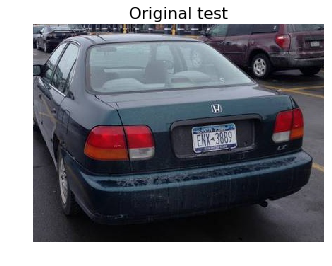

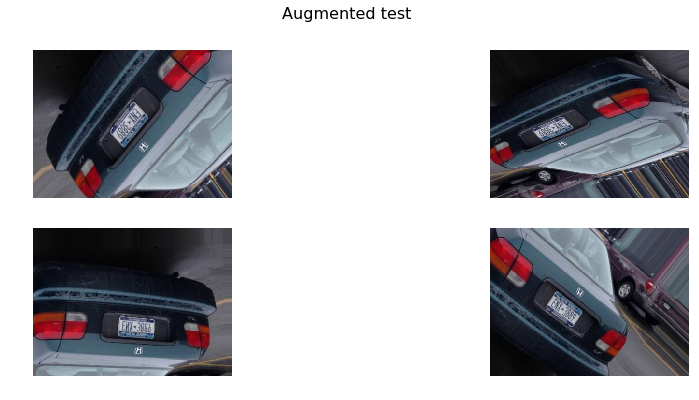

In [31]:
import random
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#Select a random image and follow the next step
datagen = ImageDataGenerator(rotation_range=45, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             zoom_range=0.3, 
                             vertical_flip=True,
                             horizontal_flip=True, 
                             fill_mode="nearest")
#Load example image
file_list = glob.glob("Dataset/test/*/*")
img_path = random.choice(file_list)
img = load_img(img_path)
car_class = img_path.split("/")[1]
plt.imshow(img)
plt.axis("off")
plt.title("Original " + car_class, fontsize=16)

img = img_to_array(img)
img = img.reshape((1,) + img.shape)
#Apply different augmentation techniques
n_augmentations = 4
plt.figure(figsize=(15, 6))    
i = 0
for batch in datagen.flow(img, 
                          batch_size=1, 
                          seed=21):
    
    plt.subplot(2, int(np.ceil(n_augmentations * 1. / 2)), i + 1)
    plt.imshow(array_to_img(batch[0]))
    plt.axis("off")
    plt.suptitle("Augmented " + car_class, fontsize=16)    
    
    i += 1
    if i >= n_augmentations:
        break

### Finalize Augmented Dataset for Training 

![Data Augmentation](assets/EDA_1-5.png)

By using the augmentation techniques we have learned, we can oversample minority classes in training set. We are not going to do these steps in validation or test in order not to create any bias on the data. 

**Activity**

Click the cell below and then click **Run**.

In [32]:
#Oversampling Minority Classes in Training Set
def data_augment(data_dir):
    list_of_images = os.listdir(data_dir)
    datagen = ImageDataGenerator(rotation_range=45, 
        horizontal_flip=True, 
        fill_mode="nearest")
    for img_name in list_of_images:
        tmp_img_name = os.path.join(data_dir, img_name)
        img = load_img(tmp_img_name)
        img = img_to_array(img)
        img = img.reshape((1,) + img.shape)

        batch = datagen.flow(img, 
            batch_size=1, 
            seed=21,
            save_to_dir=data_dir, 
            save_prefix=img_name.split(".jpg")[0] + "augmented", 
            save_format="jpg")

        batch.next()

classes_to_augment = [
    "toyota_camry_2014",
    "nissan_altima_2014",
    "toyota_corolla_2013",
    "gmc_sierra_2012"]

for class_names in classes_to_augment:
    print("Currently Augmenting:", class_names)
    data_dir = os.path.join(train_folder, class_names)
    data_augment(data_dir)

Currently Augmenting: toyota_camry_2014
Currently Augmenting: nissan_altima_2014
Currently Augmenting: toyota_corolla_2013
Currently Augmenting: gmc_sierra_2012


### Resize Images

![Resize Images](assets/EDA_1-6.png)

Depending on the toplogy, we need to resize the images with the expected image format. Since we're going to be using InceptionV3 in the next section we're going to match the size, 299x299, for that topology. 

**Activity**

Click the cell below and then click **Run**.

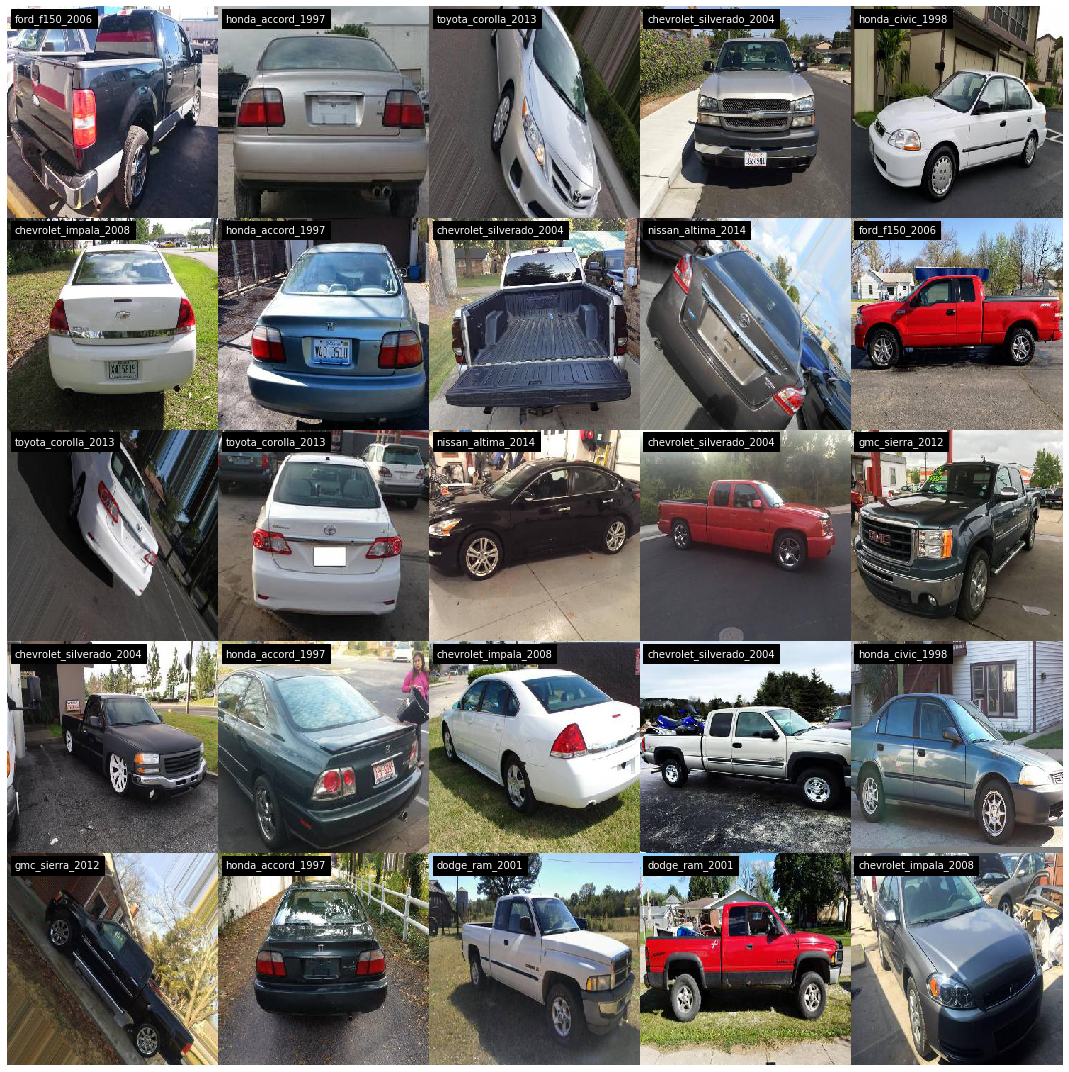

In [33]:
from functools import partial

#Resize Images
if __name__ == '__main__':
    pool = Pool()
    image_list = glob.glob(train_folder + "/*/*")
    func = partial(vmmr_utils.resize_image, size=299)
    pool.map(func, image_list)
    pool.close()

vmmr_utils.display_images(train_folder)

### Look at Distribution of Selected Classes again

![View New Data Distribution](assets/EDA_1-7.png)

Now that we've done some augmentation to the dataset we want to see how the distribution has changed compared to before the augmentation.  In this case we're only going to be looking at the train folder, since we only augmented the train dataset, so the numbers will be slightly lower than the full dataset distribution graph from earlier.  

Click the cell below and then click **Run**.

In [34]:
#Compare class distribution
line_chart = pygal.Bar(height=300)
line_chart.title = 'Most Stolen Car Training Class Distribution'
for o in os.listdir(train_folder):
    line_chart.add(o, len(os.listdir(os.path.join(train_folder, o))))
galplot(line_chart)   

## Summary 
**In this section of the training you learned**
- Fetch and visually inspect a dataset 
- Create a dataset to address a real life problem
- Image Preprocessing and Data Augmentation Techniques
- Address Imbalanced Dataset Problem
- Organize a dataset into training, validation and testing groups
- Finalize an augmented dataset for training, and testing

You now should understand ways to find a data set and to prepare a data set for machine learning and training.

## Citations

A Large and Diverse Dataset for Improved Vehicle Make and Model Recognition
F. Tafazzoli, K. Nishiyama and H. Frigui
In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR) Workshops 2017. 
